In [1]:
import  pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras 
from glob import glob
from keras.models import Sequential
from keras.layers import BatchNormalization,MaxPool2D,Dense,Conv2D,Flatten
from keras.callbacks import EarlyStopping,LearningRateScheduler
import warnings
from tqdm import tqdm
from PIL import Image
warnings.filterwarnings('ignore')

In [2]:
df=pd.DataFrame(columns=['image','label'])


In [3]:

# for a picture containing image of vehicle label is 1.

idx=0
for name in tqdm(glob('c2')):
    image=Image.open(name)
    img_seq=image.getdata()
    img=np.array(img_seq)
    img=np.reshape(img,(64,64,3))
    data=pd.DataFrame({'image':[img],'label':[1]},index=[idx])
    df=df.append(data)    
    idx+=1

100%|██████████| 8792/8792 [02:51<00:00, 51.38it/s]


In [4]:
# for a picture doesn't contain image of vehicle label is 0.

for name in tqdm(glob('m1')):
    image=Image.open(name)
    img_seq=image.getdata()
    img=np.array(img_seq)
    img=np.reshape(img,(64,64,3))
    data=pd.DataFrame({'image':[img],'label':[0]},index=[idx]) 
    df=df.append(data)
    idx+=1

100%|██████████| 8968/8968 [02:56<00:00, 50.78it/s]


In [5]:
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split
split=StratifiedShuffleSplit(n_splits=1,test_size=0.15,random_state=42)
for train_index,test_index in split.split(df,df['label']):
    train_data=df.iloc[train_index]
    test_data=df.iloc[test_index]
# train_x,test_x,train_y,test_y=train_test_split(df['image'],df['label'],random_state=42,test_size=0.15)

In [6]:
train_img,train_label=train_data['image'],train_data['label']
test_img,test_label=test_data['image'],test_data['label']

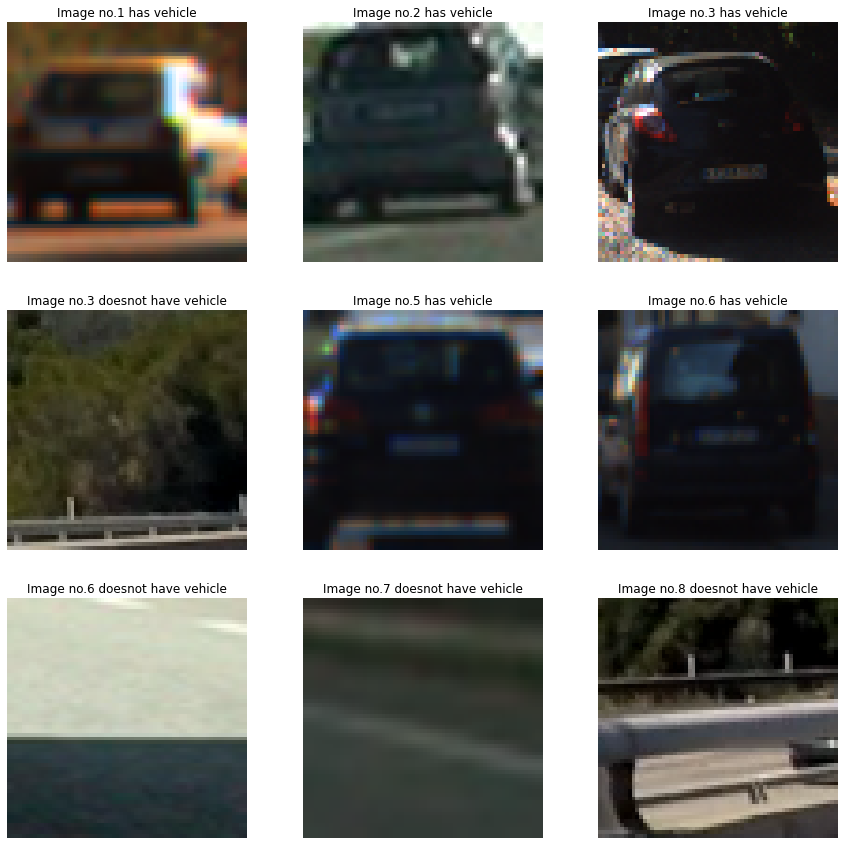

In [7]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,(i%9)+1)
    ix=np.random.randint(3000)
    if(train_label.iloc[ix]==1):
        plt.title('Image no.{0} has vehicle'.format(i+1))
    elif(train_label.iloc[ix]==0):
        plt.title('Image no.{0} doesnot have vehicle'.format(i))
    plt.axis('off')
    plt.imshow(train_img.iloc[ix])
plt.show()

In [8]:
def change_image_dimension(data):
    data=np.reshape(data.to_list(),(len(data),64,64,3))
    return data

In [9]:
train_img=change_image_dimension(train_img)
test_img=change_image_dimension(test_img)
# train_img
train_img=train_img/255.0
test_img=test_img/255.0

In [10]:
train_label=np.array(train_label,dtype=int)
test_label=np.array(test_label,dtype=int)

In [11]:
def schedule(epoch,lr):
    if epoch>=5:
        return 0.0001
    return 0.001
early_stop=EarlyStopping(monitor='val_accuracy',patience=3)
learning_rate_scheduler=LearningRateScheduler(schedule)

In [12]:
model=Sequential()
model.add(Conv2D(128,(3,3),activation='relu',input_shape=(64,64,3)))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [13]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
r=model.fit(train_img,train_label,validation_data=(test_img,test_label),epochs=10,batch_size=100,callbacks=[early_stop,learning_rate_scheduler])

Epoch 1/10
151/151 [==============================] - 19s 93ms/step - loss: 0.1477 - accuracy: 0.9324 - val_loss: 4.2140 - val_accuracy: 0.5049
Epoch 2/10
151/151 [==============================] - 13s 84ms/step - loss: 0.1397 - accuracy: 0.9615 - val_loss: 2.2970 - val_accuracy: 0.5049
Epoch 3/10
151/151 [==============================] - 13s 83ms/step - loss: 0.0220 - accuracy: 0.9924 - val_loss: 1.5763 - val_accuracy: 0.6190
Epoch 4/10
151/151 [==============================] - 13s 83ms/step - loss: 0.0094 - accuracy: 0.9969 - val_loss: 1.2157 - val_accuracy: 0.7793
Epoch 5/10
151/151 [==============================] - 13s 84ms/step - loss: 0.0118 - accuracy: 0.9955 - val_loss: 0.0446 - val_accuracy: 0.9812
Epoch 6/10
151/151 [==============================] - 13s 83ms/step - loss: 0.0039 - accuracy: 0.9985 - val_loss: 0.0102 - val_accuracy: 0.9970
Epoch 7/10
151/151 [==============================] - 13s 84ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0115 - val_accuracy:

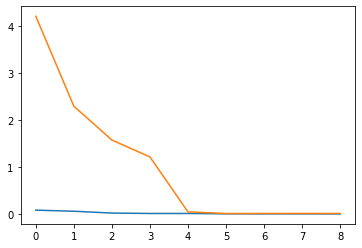

In [15]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])

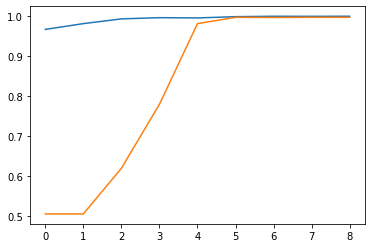

In [16]:
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])

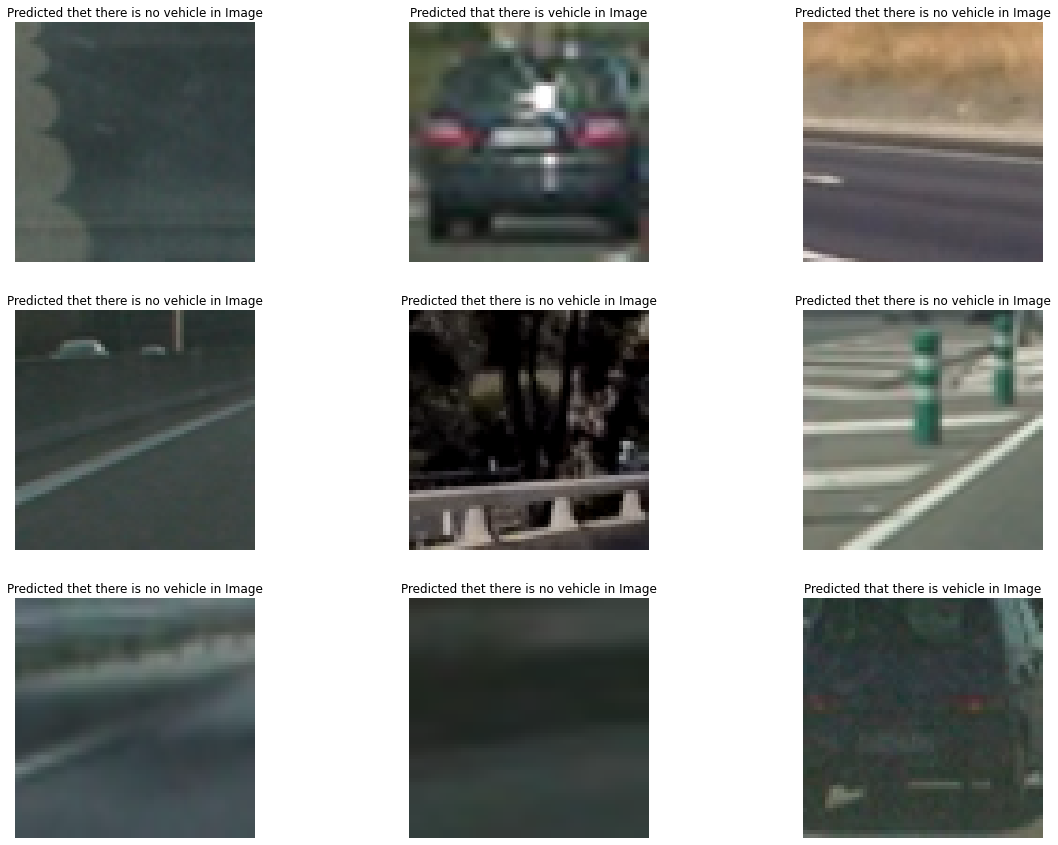

In [17]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(3,3,(i%9)+1)
    rd_idx=np.random.randint(700)
    pred_test=model.predict_classes(np.reshape(test_img[rd_idx],(-1,64,64,3)))
    if pred_test==1:
        plt.title('Predicted that there is vehicle in Image')
    else:
        plt.title('Predicted thet there is no vehicle in Image')
    plt.axis('off')
    plt.imshow(test_img[rd_idx])
plt.show()
